In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

test = pd.read_csv('test.csv')
test_shape = test.shape
train = pd.read_csv('train.csv')
train_shape = train.shape
print(test_shape)
print(train_shape)

(418, 11)
(891, 12)


In [2]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


 ### Data Dictonry
 - PassengerID - A column added by Kaggle to identify each row and make submissions easier
 - Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
 - Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
 - Sex - The passenger's sex
 - Age - The passenger's age in years
 - SibSp - The number of siblings or spouses the passenger had aboard the Titanic
 - Parch - The number of parents or children the passenger had aboard the Titanic
 - Ticket - The passenger's ticket number
 - Fare - The fare the passenger paid
 - Cabin - The passenger's cabin number
 - Embarked - The port where the passenger embarked

Anyone who has watched the movie Titanic would remember that women and children were given preference to lifeboats (as they were in real life). You would also remember the vast class disparity of the passengers.

This indicates that Age, Sex, and PClass may be good predictors of survival. We'll start by exploring Sex and Pclass by visualizing the data.

In [3]:
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index='Sex', values='Survived')
sex_pivot.plot.bar()
plt.show()

<Figure size 640x480 with 1 Axes>

We can immediately see that females survived in much higher proportions than males did.

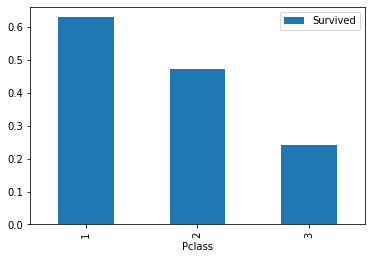

In [4]:
class_pivot = train.pivot_table(index='Pclass', values='Survived')
class_pivot.plot.bar()
plt.show()

As expected we can see a correlation

Let's take a look at the Age column using Series.describe()

In [5]:
print(train['Age'].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


The Age column contains numbers ranging from 0.42 to 80.0 (If you look at Kaggle's data page, it informs us that Age is fractional if the passenger is less than one). The other thing to note here is that there are 714 values in this column, fewer than the 891 rows we discovered that the train data set had earlier in this mission which indicates we have some missing values.

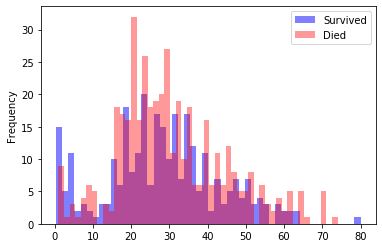

In [6]:
survived = train[train['Survived']== 1]
died = train[train['Survived']== 0]
survived['Age'].plot.hist(alpha=0.5, color = 'blue', bins=50)
died['Age'].plot.hist(alpha=.4, color = 'red', bins=50)
plt.legend(['Survived', 'Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived - where the blue bars are higher than the red bars.

To make it more useful in our model:
we can separate this continuous feature into a categorical feature by dividing it into ranges.
But before we modify this column, we have to be aware of two things.
 - Firstly, any change we make to the train data, we also need to make to the test data, otherwise we will be unable to use our model to make predictions. 
 - Secondly, we need to handle the missing values we observed above.

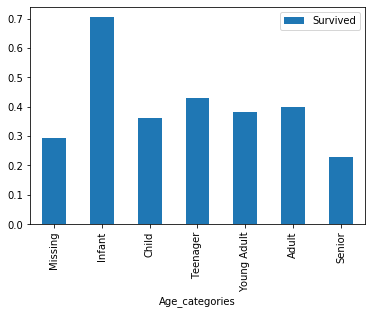

In [7]:
def process_age(df, cut_points, label_names):
    '''
    impute missing age with -0.5
    cut age column into segments
    
    Parameters:
        df: dataframe
        cut_points: bins for segments
        label_names: labels for resultant bins
        '''
    df['Age'] = df['Age'].fillna(-.05) #so the function can categorize as missing
    df['Age_categories'] = pd.cut(df['Age'], cut_points, labels = label_names)
    return df

cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
label_names = ['Missing','Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']

train = process_age(train, cut_points, label_names)
test = process_age(test, cut_points, label_names)

pivot = train.pivot_table(index='Age_categories', values='Survived')
pivot.plot.bar()
plt.show()

So far we have identified three columns that may be useful for predicting survival:

 - Sex
 - Pclass
 - Age, or more specifically our newly created Age_categories

In [8]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

While the class of each passenger certainly has some sort of ordered relationship, the relationship between each class is not the same as the relationship between the numbers 1, 2, and 3. For instance, class 2 isn't "worth" double what class 1 is, and class 3 isn't "worth" triple what class 1 is.

In order to remove this relationship, we can create dummy columns for each unique value in Pclass, sex, and Age Categories
 - We'll use pandas.get_dummies() function for that


In [9]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train, 'Pclass')
test = create_dummies(test, 'Pclass')

train = create_dummies(train, 'Sex')
test = create_dummies(test, 'Sex')

train = create_dummies(train, 'Age_categories')
test = create_dummies(test, 'Age_categories')

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,1,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,0,0,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,1,0,0,0,0,1,0,0


Now that our data has been prepared, we are ready to train our first model. The first model we will use is called Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

#Create LogisticRegression object
lr = LogisticRegression()

#Fitting Model on our training dataset

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr.fit(train[columns], train['Survived'])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Testing Accuracy
We do have a test dataframe that we could use to make predictions. We could make predictions on that data set, but because it doesn't have the Survived column.
We can split our train dataframe into two:

 - One part to train our model on (often 80% of the observations)
 - One part to make predictions with and test our model (often 20% of the observations)
 
And to avoid confusion, from here on, we're going to call the actual **'test'** data **holdout** data

The scikit-learn library has a handy model_selection.train_test_split() function that we can use to split our data.

![train_test_split](kaggle_train_test_split.svg)

In [12]:
holdout = test # from now on we will refer to this dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_x = train[columns]
all_y = train['Survived']

train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=0.20, random_state=0)

Now that we have our data split into train and test sets, we can fit our model again on our training set, and then use that model to make predictions on our test set.

In [13]:
from sklearn.metrics import accuracy_score
ir = LogisticRegression()
lr.fit(train_x, train_y)
predictions = lr.predict(test_x)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)


0.8100558659217877


Our model has an accuracy score of 81.0% when tested against our 20% test set. Given that this data set is quite small, there is a good chance that our model is overfitting, and will not perform as well on totally unseen data.

To give us a better understanding of the real performance of our model, we can use a technique called cross validation to train and test our model on different splits of our data, and then average the accuracy scores.
 - We'll use k-fold cross validation
 - We will use scikit-learn's model_selection.cross_val_score() function to automate the process.

In [14]:
from sklearn.model_selection import cross_val_score
import numpy as np
ir= LogisticRegression()
scores = cross_val_score(ir, all_x, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]
0.8024670865963002


**From the results of our k-fold validation, you can see that the accuracy number varies with each fold - ranging between 76.4% and 87.6% and our average accuracy score was 80.2%**

### Room for improvement
Improving the features:
 - Feature Engineering: Create new features from the existing data.
 - Feature Selection: Select the most relevant features to reduce noise and overfitting.
 
Improving the model:
 - Model Selection: Try a variety of models to improve performance.
 - Hyperparameter Optimization: Optimize the settings within each particular machine learning model.

## Feature Selection
We'll start by looking at feature selection. Feature selection is important because it helps to exclude features which are not good predictors, or features that are closely related to each other. Both of these will cause our model to be less accurate

Here is the list of remaining columns are haven't looked at yet:

 - SibSp - The number of siblings or spouses the passenger had aboard the Titanic
 - Parch - The number of parents or children the passenger had aboard the Titanic
 - Ticket - The passenger's ticket number
 - Fare - The fair the passenger paid
 - Cabin - The passengers cabin number
 - Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [15]:
# Using Dataframe.describe() method to give us some more information

columns=['SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
print(train[columns].describe(include='all', percentiles=[]))

             SibSp       Parch Ticket        Fare        Cabin Embarked
count   891.000000  891.000000    891  891.000000          204      889
unique         NaN         NaN    681         NaN          147        3
top            NaN         NaN   1601         NaN  C23 C25 C27        S
freq           NaN         NaN      7         NaN            4      644
mean      0.523008    0.381594    NaN   32.204208          NaN      NaN
std       1.102743    0.806057    NaN   49.693429          NaN      NaN
min       0.000000    0.000000    NaN    0.000000          NaN      NaN
50%       0.000000    0.000000    NaN   14.454200          NaN      NaN
max       8.000000    6.000000    NaN  512.329200          NaN      NaN


 - **Cabin:** has values for only 204 of the 891 rows, and even then most of the values are unique, so for now we will leave this column
 - **Embarked:** looks to be a standard categorical column with 3 unique values, much like PClass was, except that there are two missing values. We can easily fill these two missing values with the most common value, "S" which occurs 644 times.
 - **SibSp:** has values between 0-8
 - **Parch:** between 0-6
 - **Fare:** is on a different scale, with values ranging from 0-512, holdout set has missing values (we'll impute them with mean)
     - In order to make sure these values are equally weighted within our model, we'll need to **rescale** the data

In [16]:
#Using the preprocessing.minmax_scale() function will allows us to rescale our data:

from sklearn.preprocessing import minmax_scale
columns = ["SibSp","Parch","Fare"]

for col in columns:
    train[col + '_scaled'] = minmax_scale(train[col])
    holdout[col + '_scaled'] = minmax_scale(holdout[col])
    
# Impute missing values

holdout['Fare'] = holdout['Fare'].fillna(train['Fare'].mean())

train['Embarked'] = train['Embarked'].fillna('S')
holdout['Embarked'] = holdout['Embarked'].fillna('S')

# Create dummines for Embarked

train = create_dummies(train, 'Embarked')
holdout = create_dummies(holdout, 'Embarked')

In order to select the best-performing features:

 - Find features are relevant to our outcome (survival of each passenger)
 - training a logistic regression model using all of our features, and then looking at the coefficients of each feature

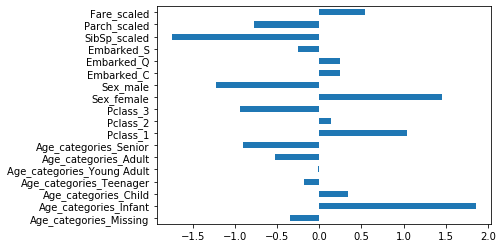

In [17]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0], index=train[columns].columns)
feature_importance.plot.barh()
plt.show()

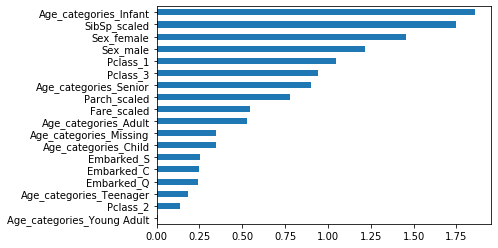

In [18]:
#Sort and turing all positive for easy interpretation
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

We'll train a new model with the **top 8** scores and check our accuracy using cross validation

In [19]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_x = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_x, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.8148019521053229


The cross validation score of **81.48%** is marginally higher than the cross validation score for the model we created with 3 features, which had a score of **80.2%**.

## Feature Engineering

 - Creating new features from your existing data
     - Binning Fare column
     - Extracting Data form Name and Cabin (text columns)

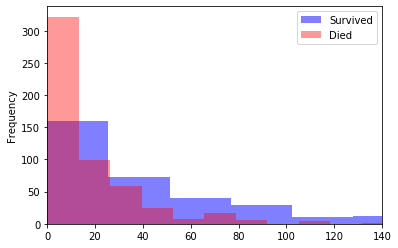

In [20]:
survived = train[train['Survived']== 1]
died = train[train['Survived']== 0]
survived['Fare'].plot.hist(alpha=0.5, color = 'blue', bins=20)
died['Fare'].plot.hist(alpha=.4, color = 'red', bins=20)
plt.legend(['Survived', 'Died'])
plt.xlim(0, 140)
plt.show()

Looking at the values, it looks like we can separate the feature into four bins to capture some patterns from the data:

 - 0-12
 - 12-50
 - 50-100
 - 100+

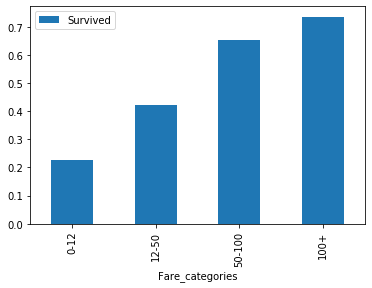

In [21]:
def process_fare(df, cut_points, label_names):
    '''
    cut age column into segments
    
    Parameters:
        df: dataframe
        cut_points: bins for segments
        label_names: labels for resultant bins
        '''
    df['Fare_categories'] = pd.cut(df['Fare'], cut_points, labels = label_names)
    return df

cut_points = [0, 12, 50, 100, 1000]
label_names = ['0-12','12-50', '50-100', '100+']

train = process_fare(train, cut_points, label_names)
holdout = process_fare(holdout, cut_points, label_names)

train = create_dummies(train, 'Fare_categories')
holdout = create_dummies(holdout, 'Fare_categories')

pivot = train.pivot_table(index='Fare_categories', values='Survived')
pivot.plot.bar()
plt.show()

In [22]:
print(train.head()["Cabin"])

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object


C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64


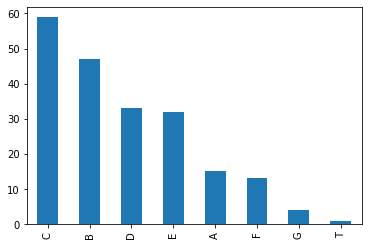

In [23]:
print(train['Cabin'].str[0].value_counts())
train['Cabin'].str[0].value_counts().plot.bar()


It seems like cabin number of each passenger will be reasonably unique to each passaner the letter is representative of the type of cabin, which could be useful data for us. We will use the pandas Series.str accessor to subset the Cabin type.

Looking at the Name column, There is a title like **'Mr'** or **'Mrs'** within each, as well as some less common titles, like the **'Countess'** from the final row of our table above`
we can categorize these into six types:

 - Mr
 - Mrs
 - Master
 - Miss
 - Officer
 - Royalty

We can use the **Series.str.extract** method and a regular expression to extract the title from each name and then use the **Series.map()** method and a predefined dictionary to simplify the titles.

In [25]:
#Defining dictionary for titles

titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

#Extracting Titles from Name and Mapping to categorize in 6 categories
extracted_titles = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'] = extracted_titles.map(titles)

extracted_titles = holdout['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
holdout['Title'] = extracted_titles.map(titles)

#Extracting Cabin Type and Filling missing with 'Unknown'

train['Cabin_type'] = train['Cabin'].str[0]
train['Cabin_type'] = train['Cabin_type'].fillna('Unknown')

holdout['Cabin_type'] = holdout['Cabin'].str[0]
holdout['Cabin_type'] = holdout['Cabin_type'].fillna('Unknown')

for column in ['Title', 'Cabin_type']:
    train = create_dummies(train, column)
    holdout = create_dummies(holdout, column)

We now have 34 possible feature columns we can use to train our model.
One thing to be aware of is **collinearity**.
 - We can spot collinearity by plotting correlations between each pair of variables in a **heatmap**.

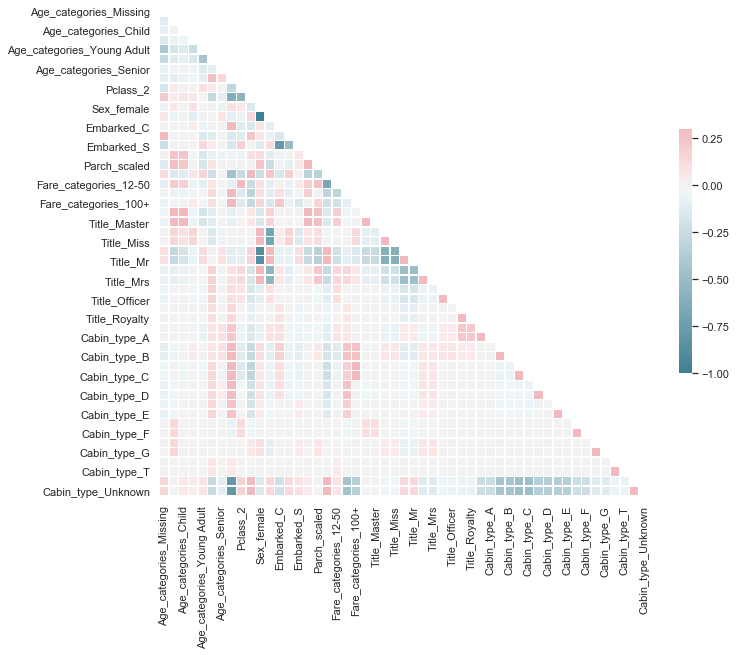

In [27]:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
               square=True, linewidth=.5, cbar_kws={'shrink': .5})
    plt.show()
    
    
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

 - We can see that there is a high correlation between **Sex_female/Sex_male** and **Title_Miss/Title_Mr/Title_Mrs.** 
     - We will remove the columns Sex_female and Sex_male
 - We will also remove one of each of our dummy variables to reduce the collinearity in each:
     - Pclass_2
     - Age_categories_Teenager
     - Fare_categories_12-50
     - Title_Master
     - Cabin_type_A

We will be using the feature_selection.RFECV class which performs recursive feature elimination with cross-validation  to select the most relevent features for our model

In [28]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_x = train[columns]
all_y = train['Survived']

lr= LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_x, all_y)

optimized_columns = all_x.columns[selector.support_]

In [29]:
print(optimized_columns)

Index(['Age_categories_Infant', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_3', 'Embarked_C',
       'Embarked_Q', 'SibSp_scaled', 'Parch_scaled', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mr',
       'Title_Mrs', 'Title_Mrs', 'Title_Officer', 'Title_Officer',
       'Title_Royalty', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_D',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_E', 'Cabin_type_G',
       'Cabin_type_G', 'Cabin_type_Unknown'],
      dtype='object')


Let's train a model using cross validation using these columns and check the score

In [32]:
all_x = train[optimized_columns]
all_y = train['Survived']
lr = LogisticRegression()
scores = cross_val_score(lr, all_x, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.821644251503802


This model scores **82.3%**, a modest improvement compared to the **81.5%** from our earlier model.